## Análisis preliminar de datos

A continuación se presenta un primer análisis basado en los datos del Censo INE 2011, publicados en la página web del Instituto.

Además se utilizan varios conjuntos de datos disponibilizados en la web. Se realizó un pre-procesamiento para seleccionar variables relevantes, reduciendo el volúmen de datos y por tanto los requerimientos informáticos para su acceso.

Como capas de información geográfica se se cuenta la capas de polígonos de departamento y de puntos de localidades del INE, identificando las capitales departamentales en esta última capa.

Se incluye una matriz de distancias entre cada centro medio de población, calculada con la API Google Distance Matrix, que consta de distancias a pie por la red de caminería entre el centro medio de población de cada departamento, obteniendo una matriz con 342 valores ((19x19)-19).

Se prefirió usar el centro medio de población, en detrimento del centroide o la capital departamental. El centro medio de población se calcula transfiriendo el conteo de habitantes del segmento censal al centroide de dicho segmento, aplicando luego la siguiente fórmula:

$$
\overline{X}_w=\frac{\sum_{i=1}^{n}w_{i}X_{i}}{\sum_{i=1}^{n} w_{i}}
$$


$$
\overline{Y}_w=\frac{\sum_{i=1}^{n}w_{i}Y_{i}}{\sum_{i=1}^{n} w_{i}}
$$

dónde

$$w = peso$$

En este caso el "peso" (w) sería la población, en tanto que "x" e "y" son las coordenadas cartográficas de cada centroide.

De esta forma se obtiene un par de coordenadas para cada departamento, que representa ese centro medio.

El PBI departamental de toma de la información producida y publicada por OPP **(cita).**

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

from shapely import wkt
from shapely.geometry import shape, LineString, Point
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [2]:
# rutas a datos
censo_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/personas_censo_2011.zip'
pbi_url    = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/pbi_departamental.csv'
md_url     = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/df_distancias_centro_poblacion.csv'
deptos_url = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/ine_deptos.gpkg'
local_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/ine_localidades.gpkg'
cpobl_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/centro_poblacion.gpkg'

In [3]:
# carga datos desde GitHub

# Datos censales
censo = pd.read_csv(censo_url, compression='zip', header=0, sep=',', quotechar='"')

# PBI departamental
pbi = pd.read_csv(pbi_url)

# matriz de distancias
md = pd.read_csv(md_url)
md.drop(['latlon_ori', 'latlon_des'], axis=1, inplace=True)

# carga capa departamentos INE pg
deptos = gpd.read_file(deptos_url)

# agrega centroides de departamentos
deptos['centroide'] = deptos['geometry'].centroid

# carga capa localidades INE pt
localidad = gpd.read_file(local_url)
localidad.CODLOC = localidad.CODLOC.astype(int)

# centro de población
centro_pobl = gpd.read_file(cpobl_url)

# filtra capitales departamentales de las localidades INE
capital = localidad[localidad.CAPITAL==True].reset_index(drop=True)

In [4]:
# calcula la población de cada departamento
poblacion = censo[['DPTO', 'LOC']].groupby(by=['DPTO']).count()
poblacion.rename(columns={'LOC': 'poblacion'}, inplace=True)

# genera dataframe con datos por departamento
datos_dpto = pd.merge(pbi, poblacion, on='DPTO')

In [5]:
datos_dpto.head()

,DPTO,NOMBRE,miles_de_pesos,porcentaje_pbi,poblacion
0,2,ARTIGAS,14214980,"1,5",73377
1,3,CANELONES,86306492,"9,3",520173
2,4,CERRO LARGO,17048887,"1,8",84698
3,5,COLONIA,43788749,"4,7",123203
4,6,DURAZNO,13023942,"1,4",57084


**Análisis por departamentos**

Dada la menor complejidad, se comienza por el análisis de los flujos entre departamentos.
La base de personas del Censo INE 2011 se filtra según el siguiente criterio:
- Variable "PERMI07" (lugar de residencia 5 años antes) con valores:
    - 2 = en otra localidad o paraje de este departamento
    - 3 = en otro departamento
    
Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido relevadas en el departamento de "destino" al momento de la aplicación del formulario censal.

In [6]:
# define vector de nombres de columnas para filtrar
cols = ['DPTO', 'LOC', 'SECC', 'SEGM', 'PERMI07', 'PERMI07_1', 'PERMI07_2', 'PERMI07_3', 'PERMI07_4']

# filtra
p_migr = censo[(censo.PERMI07 == 2) | (censo.PERMI07 == 3)][cols]

# cambia DPTO a tipo entero
p_migr.DPTO = p_migr.DPTO.astype(int)

# print(p_migr.shape[0])

# Hay 26.449 residentes en localidades rurales
# print(p_migr[( p_migr.LOC == 900 )].shape[0])

# identifica depto de residencia anterior
p_migr['depto_origen'] = p_migr.loc[:,('PERMI07_2')]
p_migr.depto_origen.fillna(p_migr.DPTO, inplace=True)

# convierte a string
p_migr.loc[:,('depto_origen')] = p_migr.loc[:,('depto_origen')].astype(int)

# renombra DPTO
p_migr.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

In [47]:
p_migr

,depto_destino,LOC,SECC,SEGM,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,depto_origen
5,1,20,1,1,3,NaN,3.0,732.0,0,3
40,1,20,1,1,3,NaN,17.0,220.0,0,17
50,1,20,1,1,3,NaN,18.0,220.0,0,18
64,1,20,1,1,3,NaN,2.0,220.0,0,2
110,1,20,1,1,3,NaN,12.0,320.0,0,12
...,...,...,...,...,...,...,...,...,...,...
3285865,19,967,3,604,2,220.0,NaN,NaN,0,19
3285866,19,968,2,407,3,NaN,14.0,621.0,0,14
3285867,19,968,2,407,3,NaN,13.0,822.0,0,13
3285874,19,971,3,404,3,NaN,14.0,942.0,0,14


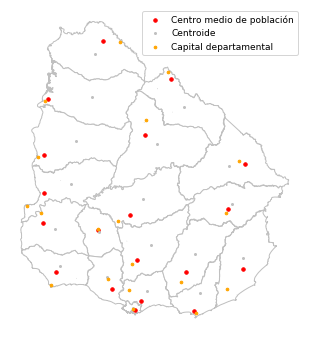

In [7]:
# plot de las capas de departamentos y localidades
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# deptos
deptos.plot(color='w', edgecolor='silver',ax=ax)

# localidades
centro_pobl.plot(markersize=12, color = 'red', ax = ax, label='Centro medio de población')
deptos.geometry.centroid.plot(markersize=4, color = 'silver', ax = ax, label='Centroide')
capital.plot(markersize=7, color = 'orange', ax = ax, label='Capital departamental')

# título
# pl.title("Centroide, centro de población y capitales departamentales", size=10)

# referencias
plt.legend(fontsize=9)

metadatos_figs = {'Author': '''Guillermo D'Angelo''', 'Title': 'Mapa Centro de Población'}

plt.savefig('mapas_graficas/centro_poblacion.pdf', bbox_inches='tight',
            metadata = metadatos_figs )

In [8]:
# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr[['depto_origen', 'depto_destino']]

flujos_deptos = flujos_deptos[flujos_deptos.depto_origen != flujos_deptos.depto_destino]

flujos_deptos['personas_mig'] = 1

# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).sum()

print('Cantidad de díadas ', grupo.shape[0])

grupo.head()

Cantidad de díadas  342


personas_mig
depto_origen depto_destino              
1            2                       914
             3                     33127
             4                      1387
             5                      2100
             6                       982

In [9]:
print(grupo.reset_index().head().to_markdown(showindex=False))

|   depto_origen |   depto_destino |   personas_mig |
|---------------:|----------------:|---------------:|
|              1 |               2 |            914 |
|              1 |               3 |          33127 |
|              1 |               4 |           1387 |
|              1 |               5 |           2100 |
|              1 |               6 |            982 |


A continuación se presentan dichos datos en formato de matriz simétrica, refiriéndose a cada departamento con su código INE.

In [10]:
# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos, index ='depto_origen', columns='depto_destino', fill_value=0,
                        aggfunc=sum, margins=True, margins_name='Total',)
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [11]:
# lista de nombres deptos para generar tabla en latex
nomdep = ['Mvdeo.', 'Artigas', 'Can.', 'C. Largo', 'Colonia', 'Durazno',
          'Flores', 'Florida', 'Lavalleja','Maldonado', 'Paysandú', 'R. Negro', 'Rivera',
          'Rocha', 'Salto', 'San José', 'Soriano', 'Tacuarembó', 'T. y Tres']

coddep = np.arange(1, 20, 1).tolist()

# guarda tabla en latex
# cabecera = datos_dpto.sort_values('DPTO')['NOMBRE'].to_list()
# cabecera.append('Total')

matrix_tex = matrix
matrix_tex.rename(index=dict(zip(coddep, nomdep)), inplace=True)

# setea ancho de columnas
ancho = 'p{0.7cm}'
colformato='l' + ancho * 20

matrix_tex.to_latex(buf= "tablas/matriz_orig_dest.tex", bold_rows=False,
                    column_format = colformato,
                    caption= 'Matriz de movimientos entre departamentos (Censo INE 2011).')

In [12]:
# # guarda tabla en markdown
# matrix_md = matrix.reset_index().to_markdown(showindex=False)
# matrix_md = matrix_md.replace("""(""", '')
# matrix_md = matrix_md.replace(""")""", '')
# matrix_md = matrix_md.replace("""'""", '')
# matrix_md = matrix_md.replace(""",""", '')
# matrix_md = matrix_md.replace("personas_mig ", '')
# matrix_md = matrix_md.replace("depto_origen", 'Cod. Depto.')
# f = open("tablas/matriz_orig_dest.md", "w")
# f.write(matrix_md)
# f.close()

Se contruye un conjunto de datos que contiene la siguiente información para cada díada de departamentos:
- Los datos son los totales de personas que declaran haber vivido antes en el departamento de origen
- La población total en origen y destino
- El PBI en el departamento de destino y el logaritmo de dicho valor
- La distancia entre cada centro medio de población y el logaritmo de dicho valor

In [13]:
# unimos todo en un dataframe de díadas
df_agrupado = grupo.reset_index()

# agrega codigo único
df_agrupado.insert(0, 'cod', (df_agrupado['depto_origen'].astype(str)
                   + df_agrupado['depto_destino'].astype(str).str.zfill(2)).astype(int))

# recupera datos de otros data frames
merge1 = pd.merge(df_agrupado, datos_dpto[['DPTO', 'NOMBRE', 'miles_de_pesos', 'poblacion']], left_on='depto_origen', right_on='DPTO')
merge2 = pd.merge(merge1, datos_dpto[['DPTO', 'NOMBRE', 'miles_de_pesos', 'poblacion']], left_on='depto_destino', right_on='DPTO')
merge3 = pd.merge(merge2, md[['cod', 'distancia']], on='cod')
datos_diadas = merge3.drop(['DPTO_x', 'DPTO_y'], axis=1)

# borra productos intermedios
del(merge1, merge2, merge3)

# renombra columnas
datos_diadas.rename(columns={'NOMBRE_x': 'nom_depto_orig', 'NOMBRE_y': 'nom_depto_des',
                             'miles_de_pesos_x': 'pbi_origen', 'miles_de_pesos_y': 'pbi_destino',
                             'distancia': 'dist', 'poblacion_x': 'pob_origen', 'poblacion_y': 'pob_destino'},
                    inplace=True)

# incorporamos el logaritmo del PBI departamental en destino
datos_diadas = datos_diadas.assign(log_pbi_destino = lambda x: np.log(x['pbi_destino']))

# incorporamos el logaritmo de las distancias entre díadas
datos_diadas = datos_diadas.assign(log_dist = lambda x: np.log(x['dist']))

# reordena variables
order = ['cod', 'depto_origen', 'nom_depto_orig', 'depto_destino', 'nom_depto_des', 'personas_mig', 'pbi_origen',
         'pob_origen', 'pbi_destino', 'pob_destino', 'dist', 'log_pbi_destino', 'log_dist']

datos_diadas = datos_diadas[order]
datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601916,16.469807,13.307873
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406722,16.469807,12.915885
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556293,16.469807,13.229050
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446276,16.469807,13.008693


In [14]:
# define función para hacer lineas a partir de códigos origen-destino y una geografía conocida
# fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Unconstrained%20Spatial%20Interaction%20Models.ipynb

def _odline(orig, dest, geo, zonecode):
    return LineString([deptos[geo[zonecode] == orig].centroid.values[0], geo[geo[zonecode] == dest].centroid.values[0]])

# Makes a geodataframe of flows
def odflow(flowdata, origin, destination, flow_value, geo, zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin], x[destination], geo, zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[flow_value]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows, geometry=lines, crs = geo.crs)

# aplica función
flows = odflow(datos_diadas,'depto_origen', 'depto_destino', 'personas_mig', deptos,'cod_ine')

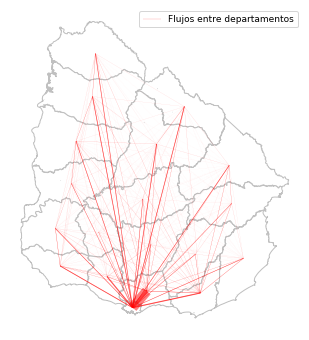

In [15]:
# plot de flujos
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# capa de departamentos
deptos.plot(color='w', edgecolor='silver' ,ax=ax)

# máximo de flujos para escalado
maxflow = float(max(flows['personas_mig']))

# título
# pl.title("Representación gráfica de las migraciones recientes", size=10)

# plotea flows, calcula ancha de línea con una función sobre 'personas_mig'
flows.plot(linewidth = flows.apply(lambda x: (x['personas_mig']/maxflow)*10, axis=1),
           color = 'red',ax=ax, label='Flujos entre departamentos', alpha=0.5)

ax.set_aspect('equal')

# referencias
plt.legend(fontsize=9)

plt.savefig('mapas_graficas/links_depto.pdf', bbox_inches='tight',
            metadata = metadatos_figs )

Text(0.5, 0, 'Distancia (m)')

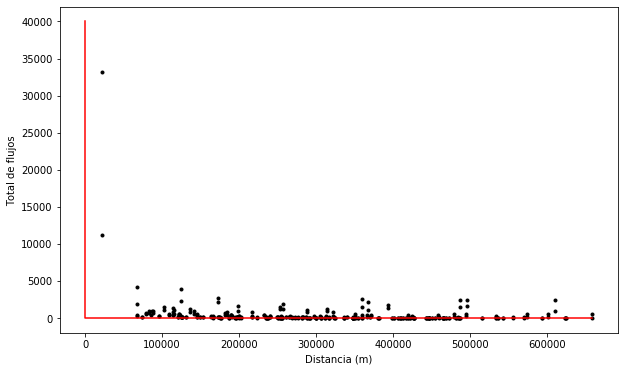

In [16]:
# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(datos_diadas['dist'], datos_diadas['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.005, datos_diadas['dist'].max(), 1000)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# Aetiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

# se ven dos outlyers claramente, deben ser Mvdeo y Canelones.

Text(0.5, 0, 'Distancia (m)')

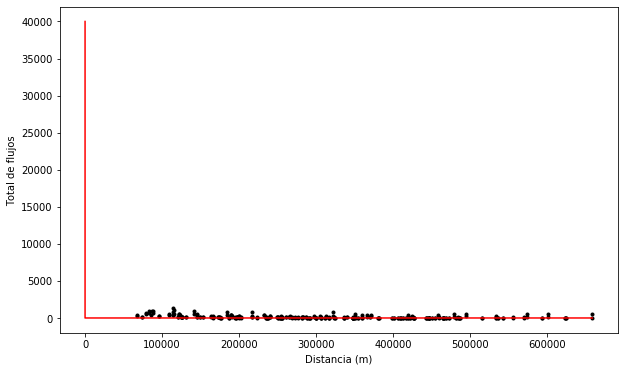

In [17]:
# mismo gráfico sin Mvdeo.
sin_mvo = datos_diadas[(datos_diadas['depto_origen'] > 1) & (datos_diadas['depto_destino'] > 1)]

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(sin_mvo['dist'], sin_mvo['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.005, sin_mvo['dist'].max(), 100)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# Etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

Text(0.5, 0, 'Población en origen')

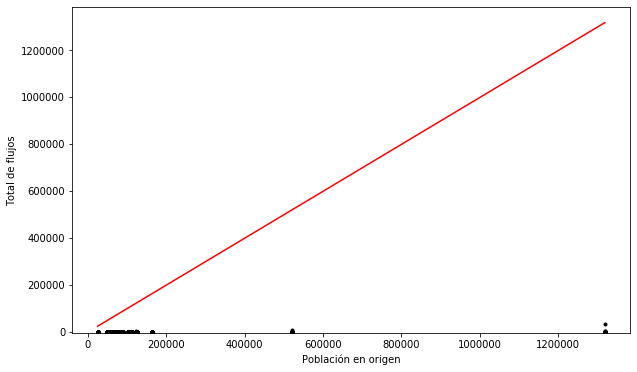

In [18]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(10,6))

# Plot data points
ax.scatter(datos_diadas['pob_origen'], datos_diadas['personas_mig'], marker='.', color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pob_origen'].min(), datos_diadas['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, datos_diadas['pob_origen'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

Text(0.5, 0, 'PBI en destino')

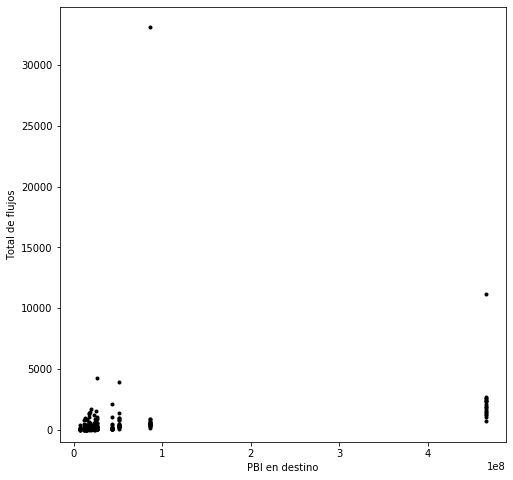

In [19]:
# Plot de PBI en destino contra personas migrantes
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(datos_diadas['pbi_destino'], datos_diadas['personas_mig'], marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pbi_destino'].min(), datos_diadas['pbi_destino'].max(), 100)
yvals = np.power(xvals,1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000, datos_diadas['personas_mig'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino")

# Modelo restringido en origen

1 $$T_{ij} = A_{i}O_{i}W_{j}^{\alpha}d_{ij}^{-\beta}$$

dónde

2 $$O_{i} = \sum_{j}T_{ij}$$


3 $$A_{i} = \frac{1}{\sum_{j}W_{j}^{\alpha}d_{ij}^{-\beta}}$$



En el modelo restringido en origen $O_{i}$ no tiene parámetro dado que representa valores conocidos. $A_{i}$ es un factor de balance que refiere a cada origen $i$. Más específicamente $A_{i}$ permite que la suma de los valores estimados sea igual al total conocido $O_{i}$

El modelo es re-especificado como un modelo de regresión de Poisson. Se asume una vinculación

**We set about re-specifying the Production-Constrained model as a Poisson regression model in a similar way to how we did before. We need to take logs of the right-hand side of equation and assume that these are logarithmially linked to the Poisson distributed mean ($\lambda_{ij}$) of the $T_{ij}$ variable. Equation 1 (above) then becomes:**


4   $$ \lambda_{ij} = \exp( \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij} )$$



In [20]:
# el depto_origen se cambio a tipo texto para que no sea tomada como variable numérica por la regresión
#  datos_diadas['depto_origen'] = datos_diadas.depto_origen.astype(str)

# respalda el objeto para usarlo en el otro modelo
dd=datos_diadas

In [21]:
datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601916,16.469807,13.307873
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406722,16.469807,12.915885
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556293,16.469807,13.229050
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446276,16.469807,13.008693


Resultados de la aplicación del modelo restringido en origen:

In [22]:
# Here we specify a model with no intercept (given by the -1 in the formula)
# In practice this means that all AiOis are estimated against an intercept of zero.
# Including the interval would mean setting the first borough in OrigNewCode to the intercept
# and interpreting all other categories in relation to that, which is less useful but would still work.
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"
prodSim = smf.glm(formula=formula, data = datos_diadas, family = sm.families.Poisson()).fit()
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      321
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14969.
Date:                Thu, 18 Jun 2020   Deviance:                       27710.
Time:                        19:31:34   Pearson chi2:                 3.00e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]            0.8851      0.075     11.878      0.000       0.739       1.031
nom_depto_orig[CANELONES]          0.3742      0.069      5.425      0.000       0.239       0.509
nom_depto_orig[CERRO LARGO]        0.5135      0.074      6.917      0.000       0.368       0.659
nom_depto_orig[COLONIA]            0.1597      0.073      2.185      0.029       0.016       0.303
nom_depto_orig[DURAZNO]           -0.0886      0.073     -1.209      0.227      -0.232       0.055
nom_depto_orig[FLORES]            -1.0480      0.075    -13.914      0.000      -1.196      -0.900
nom_depto_orig[FLORIDA]           -0.3439      0.073     -4.742      0.000      -0.486      -0.202
nom_depto_orig[LAVALLEJA]         -0.3433      0.073     -4.695      0.000      -0.487      -0.200
nom_depto_orig[MALDONADO]          0.2222      0.073      3.063      0.002       0.080       0.364
nom_depto_orig[MONTEVIDEO]         2.5701      0.067     38.489      0.000       2.439       2.701
nom_depto_orig[PAYSANDU]           0.4979      0.073      6.811      0.000       0.355       0.641
nom_depto_orig[RIO NEGRO]         -0.0173      0.073     -0.236      0.814      -0.161       0.127
nom_depto_orig[RIVERA]             0.7010      0.074      9.434      0.000       0.555       0.847
nom_depto_orig[ROCHA]              0.0426      0.074      0.574      0.566      -0.103       0.188
nom_depto_orig[SALTO]              0.7578      0.074     10.264      0.000       0.613       0.902
nom_depto_orig[SAN JOSE]          -0.4935      0.072     -6.845      0.000      -0.635      -0.352
nom_depto_orig[SORIANO]            0.2418      0.073      3.320      0.001       0.099       0.385
nom_depto_orig[TACUAREMBO]         0.6482      0.074      8.811      0.000       0.504       0.792
nom_depto_orig[TREINTA Y TRES]    -0.0264      0.074     -0.355      0.722      -0.172       0.119
log_pbi_destino                    0.8527      0.002    355.636      0.000       0.848       0.857
log_dist                          -0.7830      0.003   -224.889      0.000      -0.790      -0.776
==================================================================================================
"""

In [23]:
mro_latex = prodSim.summary().as_latex()
f = open("tablas/mro.tex", "w")
f.write(mro_latex)
f.close()

De los resultados se desprende un parámetro $\alpha$ relacionado a la actractividad del destino de 0,8527.

El parámetro $\beta$ relativo al decaimiento por la distancia es de -0,7830

El coeficiente para cada origen es el valor registrado $A_{i}O_{i}$ para ese origen.

## Estimaciones del modelo restringido en origen

Los parámetros calculados se insertan en la ecuación nro. 4.

$$ \lambda_{ij} = \exp( \mu_{i} + 0,8527 ln W_{j}  + 0,7830 ln d_{ij} )$$


In [24]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = datos_diadas.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = datos_diadas.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
datos_diadas = datos_diadas.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
datos_diadas = datos_diadas.merge(D_j,left_on='depto_destino', right_index=True)

datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist,O_i,D_j
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404,58655,1810
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601916,16.469807,13.307873,17233,1810
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406722,16.469807,12.915885,4459,1810
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556293,16.469807,13.229050,4752,1810
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446276,16.469807,13.008693,3757,1810


In [25]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# elimina caractérres no numéricos para poder mergear
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^ ABCDEFGHIJKLMNÑOPQRSTUVWXYZ]','').values)),inplace=True)

# renombre columna
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# merge
datos_diadas = datos_diadas.merge(mu_i, left_on='nom_depto_orig', right_index=True)

In [26]:
mu_i

,mu_i
ARTIGAS,0.885090
CANELONES,0.374155
CERRO LARGO,0.513520
COLONIA,0.159693
DURAZNO,-0.088643
FLORES,-1.047955
FLORIDA,-0.343882
LAVALLEJA,-0.343334
MALDONADO,0.222217
MONTEVIDEO,2.570121


In [27]:
# guarda parámetros estimados en objetos
alpha = prodSim.params[19]
beta  = prodSim.params[20]

print("alfa (log PBI destino)= " + str(alpha))
print("beta (log distancia)= " + str(beta))

alfa (log PBI destino)= 0.8527460860154981
beta (log distancia)= -0.7830145954543183


In [28]:
# genera estimación redondeada
# esta es la estimación del modelo de la ecuación 4, imputando los parámetro alfa y beta calculados
datos_diadas['prodsimest'] = np.round(np.exp(datos_diadas['mu_i']
                                             + alpha * datos_diadas['log_pbi_destino']
                                             + beta * datos_diadas['log_dist']))

In [29]:
# matriz de flujos estimada por el modelo
datos_diadas['depto_origen'] = datos_diadas.depto_origen.astype(int)

matrix_prodsim = pd.pivot_table(datos_diadas, values='prodsimest',index ='depto_origen', columns='depto_destino',fill_value=0,
                 aggfunc=sum, margins=True, margins_name='Total')

matrix_prodsim.Total = matrix_prodsim.Total.astype(int)

matrix_prodsim

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,484,29877,798,3399,1082,706,2379,1700,5038,1238,1286,770,1154,953,4712,1439,901,740,58656
2,1761,0,423,144,252,107,64,121,99,253,266,206,337,106,378,163,173,219,92,5164
3,14006,55,0,93,351,125,81,297,216,600,140,144,86,137,107,445,161,102,88,17234
4,1713,85,426,0,198,107,54,120,128,305,137,117,173,147,135,144,115,153,202,4459
5,2291,47,505,62,0,97,85,129,86,229,150,184,70,73,106,263,242,83,50,4752
6,1601,43,394,74,213,0,100,145,87,197,115,113,73,71,87,156,125,100,65,3759
7,657,16,162,24,117,63,0,54,30,73,56,57,27,24,37,80,67,35,20,1599
8,2092,29,557,49,168,86,51,0,95,217,77,74,48,63,57,192,80,59,47,4041
9,1672,27,453,58,126,58,31,106,0,363,60,58,44,93,48,120,62,49,63,3491


In [30]:
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
Mvdeo.                   0   914  33127  1387  2100   982   378  1026   825   
Artigas               2395     0    536    20   167    33    21    40    15   
Can.                 11162    74      0   274   422   223    82   670   403   
C. Largo              1805    15    435     0    63    67     5    73   131   
Colonia               2690    28    366    20     0    63    69    53    19   
Durazno               1610    32    466    64    70     0   149   404    67   
Flores                 735     2    162    13    86    90     0    76     5   
Florida               1420    13    892    37   107   307    84     0   163   
Lavalleja             1264     7    446    64    39    29    17   138     0   
Maldonado             2333    46    862   208   196    75    58   121   407   
Paysandú              2096    75    434    35   151    55    29    57    37   
R. Negro              1219    30    316    20   176    54    77    27    15   
Rivera                2390   102    584   162    77    50    22    63    49   
Rocha                 1435     8    407    59    49    18     7    45   130   
Salto                 2481   380    543    18   134    14    20    48    20   
San José              1852    15    689    31   452    59   122   252    44   
Soriano               1922     9    293    12  1053    57    90    40    33   
Tacuarembó            2611    50    596   168    79   304    79    92    50   
T. y Tres             1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
Mvdeo.          3914  1075   886  1665  1266  1547  4209  1173  1421   760   
Artigas          472   200    57   146    47   794    92    24   100     5   
Can.            1345   148   154   320   360   159   908   154   251   124   
C. Largo         810    61    41   145    95    19    49    34   135   476   
Colonia          309    71    88    34    35    68   269   513    34    23   
Durazno          198    59    62    42    61    28   124    32   212    77   
Flores            79    30    36    10    13    17   116    85    29    14   
Florida          310    47    30    46    62    19   321    51    68    64   
Lavalleja        936    28    11    25   150    15    45    11    45   221   
Maldonado          0    95    95   117   535    98   131   110    71   259   
Paysandú         420     0   640    66    50   480   116    98   229    25   
R. Negro         223   516     0    54    48   133   107   270    89     9   
Rivera           227   143    36     0    46   120    99    25   546    57   
Rocha            952    32    30    17     0    29    45    18    21   162   
Salto            484   564   161    97    38     0    99    75   166     8   
San José         230    59    55    32    47    30     0   112    53    23   
Soriano          335   181   372    18    46    98   147     0    41    16   
Tacuarembó       363   261   134   421    35   174    88    72     0    32   
T. y Tres        776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
Mvdeo.          58655  
Artigas          5164  
Can.            17233  
C. Largo         4459  
Colonia          4752  
Durazno          3757  
Flores           1598  
Florida          4041  
Lavalleja        3491  
Maldonado        5817  
Paysandú         5093  
R. Negro         3383  
Rivera           4798  
Rocha            

In [31]:
matrix_prodsim_tex = matrix_prodsim.rename(index=dict(zip(coddep, nomdep)))

matrix_prodsim_tex.to_latex(buf= "tablas/prodsim_matriz_orig_dest.tex", bold_rows=False,
                            column_format = colformato,  float_format="%.2f",
                            caption= 'Matriz de movimientos entre departamentos estimada mediante SIM restringido en origen.')

Se puede identificar la coincidencia de la matriz de los datos originales con la de los datos estimados en la columna de origen $O_{i}$, con leves diferencias producto del redondeo.

$$\sum_{j}T_{ij} = \sum_{j}\lambda_{ij} = O_{i}$$

In [32]:
# bondad de ajuste

# define una función para calcular el R cuadrado
def calcR2(obs, est):
    return np.power(np.corrcoef(obs,est),2.0)[0][1]

# define una función para calcula el error medio cuadrático
def calcRMSE(obs,est):
    return np.sqrt((np.power((obs - est),2.0)).mean())

In [33]:
printmd('**Bondad de ajuste del modelo restringido en origen**')

printmd("$R²$ = " + round(calcR2(datos_diadas['personas_mig'],datos_diadas['prodsimest']), 4).astype(str))

printmd("RMSE = " +    round(calcRMSE(datos_diadas['personas_mig'],datos_diadas['prodsimest']), 4).astype(str))


**Bondad de ajuste del modelo restringido en origen**

$R²$ = 0.9738

RMSE = 322.3049

# Modelo de doble restricción

5    $$ T_{ij} = A_{i}O_{i}B_{i}D_{j}d_{ij}^{-\beta }$$

dónde

6 $$O_{i} = \sum_{j}T_{ij}$$

7 $$D_{j} = \sum_{i}T_{ij}$$

8 $$A_{i} = \frac{1}{\sum_{j}B_{j}D_{j}d_{ij}^{-\beta}}$$

9 $$B_{j} = \frac{1}{\sum_{j}A_{i}O_{j}d_{ij}^{-\beta}}$$

La dificultad es que $A_{i}$ depende de $B_{j}$ y viceversa. Pero se puede arrivar a un valor para ambos factores fijando el valor de $B$ inicialmente como 1, y luego iterando refinando el valor de cada uno hasta que sea estable (converjan).

In [34]:
# Modelo de restricción doble

# recupera el los datos del respaldo
datos_diadas = dd
formula = "personas_mig ~ nom_depto_orig + nom_depto_des + log_pbi_destino + log_dist -1"
doubSim = smf.glm(formula=formula, data = datos_diadas, family = sm.families.Poisson()).fit()
doubSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      304
Model Family:                 Poisson   Df Model:                           37
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12550.
Date:                Thu, 18 Jun 2020   Deviance:                       22872.
Time:                        19:31:34   Pearson chi2:                 2.48e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]             0.5380      0.014     37.940      0.000       0.510       0.566
nom_depto_orig[CANELONES]           0.2740      0.011     24.521      0.000       0.252       0.296
nom_depto_orig[CERRO LARGO]         0.1850      0.015     12.446      0.000       0.156       0.214
nom_depto_orig[COLONIA]            -0.1068      0.014     -7.507      0.000      -0.135      -0.079
nom_depto_orig[DURAZNO]            -0.3571      0.016    -22.494      0.000      -0.388      -0.326
nom_depto_orig[FLORES]             -1.2994      0.024    -54.248      0.000      -1.346      -1.252
nom_depto_orig[FLORIDA]            -0.5964      0.015    -38.758      0.000      -0.627      -0.566
nom_depto_orig[LAVALLEJA]          -0.6305      0.016    -38.312      0.000      -0.663      -0.598
nom_depto_orig[MALDONADO]          -0.0194      0.013     -1.498      0.134      -0.045       0.006
nom_depto_orig[MONTEVIDEO]          2.2493      0.007    308.272      0.000       2.235       2.264
nom_depto_orig[PAYSANDU]            0.2196      0.014     15.811      0.000       0.192       0.247
nom_depto_orig[RIO NEGRO]          -0.2819      0.017    -16.831      0.000      -0.315      -0.249
nom_depto_orig[RIVERA]              0.3692      0.014     25.551      0.000       0.341       0.398
nom_depto_orig[ROCHA]              -0.2716      0.017    -16.393      0.000      -0.304      -0.239
nom_depto_orig[SALTO]               0.4579      0.014     33.323      0.000       0.431       0.485
nom_depto_orig[SAN JOSE]           -0.7042      0.015    -45.874      0.000      -0.734      -0.674
nom_depto_orig[SORIANO]            -0.0112      0.014     -0.787      0.431      -0.039       0.017
nom_depto_orig[TACUAREMBO]          0.3430      0.013     25.752      0.000       0.317       0.369
nom_depto_orig[TREINTA Y TRES]     -0.3415      0.017    -19.784      0.000      -0.375      -0.308
nom_depto_des[T.CANELONES]          0.2844      0.030      9.394      0.000       0.225       0.344
nom_depto_des[T.CERRO LARGO]        0.1973      0.030      6.571      0.000       0.138       0.256
nom_depto_des[T.COLONIA]           -0.2852      0.029     -9.817      0.000      -0.342      -0.228
nom_depto_des[T.DURAZNO]           -0.0655      0.031     -2.136      0.033      -0.126      -0.005
nom_depto_des[T.FLORES]            -0.3577      0.036    -10.013      0.000      -0.428      -0.288
nom_depto_des[T.FLORIDA]           -0.3105      0.030    -10.411      0.000      -0.369      -0.252
nom_depto_des[T.LAVALLEJA]         -0.3122      0.031    -10.098      0.000      -0.373      -0.252
nom_depto_des[T.MALDONADO]          0.3109      0.028     11.238      0.000       0.257       0.365
nom_depto_des[T.MONTEVIDEO]         0.0191      0.033      0.574      0.566      -0

In [35]:
# recupera los valores estimados
datos_diadas['doubsim_ajustado'] = np.round(doubSim.predict())

datos_diadas['depto_origen'] = datos_diadas.depto_origen.astype(int)

# matriz de los valores estimados
pd.pivot_table(datos_diadas, values='doubsim_ajustado', index ='depto_origen',
               columns='depto_destino', fill_value=0, aggfunc=sum, margins=True)

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,All
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,518,31743,1002,2410,1005,496,1633,1194,6302,1091,899,958,1262,1118,4017,1030,1138,839,58655.0
2,1666,0,551,177,189,102,47,91,75,346,226,142,378,120,404,158,125,263,105,5165.0
3,13457,73,0,145,312,144,71,251,187,930,154,125,133,186,157,480,144,161,123,17233.0
4,1601,88,547,0,149,101,40,89,93,405,121,84,204,160,156,138,85,187,213,4461.0
5,2150,52,658,83,0,95,61,98,67,321,136,130,92,87,129,247,173,110,62,4751.0
6,1514,48,512,95,160,0,69,106,66,274,104,82,93,83,105,150,92,127,76,3756.0
7,628,19,212,31,87,58,0,41,23,104,51,41,35,29,45,76,49,46,24,1599.0
8,1919,33,697,65,128,83,38,0,71,297,71,55,63,73,71,180,61,78,56,4039.0
9,1511,30,558,74,95,56,23,77,0,458,56,42,56,102,58,113,47,65,71,3492.0


In [36]:
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
Mvdeo.                   0   914  33127  1387  2100   982   378  1026   825   
Artigas               2395     0    536    20   167    33    21    40    15   
Can.                 11162    74      0   274   422   223    82   670   403   
C. Largo              1805    15    435     0    63    67     5    73   131   
Colonia               2690    28    366    20     0    63    69    53    19   
Durazno               1610    32    466    64    70     0   149   404    67   
Flores                 735     2    162    13    86    90     0    76     5   
Florida               1420    13    892    37   107   307    84     0   163   
Lavalleja             1264     7    446    64    39    29    17   138     0   
Maldonado             2333    46    862   208   196    75    58   121   407   
Paysandú              2096    75    434    35   151    55    29    57    37   
R. Negro              1219    30    316    20   176    54    77    27    15   
Rivera                2390   102    584   162    77    50    22    63    49   
Rocha                 1435     8    407    59    49    18     7    45   130   
Salto                 2481   380    543    18   134    14    20    48    20   
San José              1852    15    689    31   452    59   122   252    44   
Soriano               1922     9    293    12  1053    57    90    40    33   
Tacuarembó            2611    50    596   168    79   304    79    92    50   
T. y Tres             1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
Mvdeo.          3914  1075   886  1665  1266  1547  4209  1173  1421   760   
Artigas          472   200    57   146    47   794    92    24   100     5   
Can.            1345   148   154   320   360   159   908   154   251   124   
C. Largo         810    61    41   145    95    19    49    34   135   476   
Colonia          309    71    88    34    35    68   269   513    34    23   
Durazno          198    59    62    42    61    28   124    32   212    77   
Flores            79    30    36    10    13    17   116    85    29    14   
Florida          310    47    30    46    62    19   321    51    68    64   
Lavalleja        936    28    11    25   150    15    45    11    45   221   
Maldonado          0    95    95   117   535    98   131   110    71   259   
Paysandú         420     0   640    66    50   480   116    98   229    25   
R. Negro         223   516     0    54    48   133   107   270    89     9   
Rivera           227   143    36     0    46   120    99    25   546    57   
Rocha            952    32    30    17     0    29    45    18    21   162   
Salto            484   564   161    97    38     0    99    75   166     8   
San José         230    59    55    32    47    30     0   112    53    23   
Soriano          335   181   372    18    46    98   147     0    41    16   
Tacuarembó       363   261   134   421    35   174    88    72     0    32   
T. y Tres        776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
Mvdeo.          58655  
Artigas          5164  
Can.            17233  
C. Largo         4459  
Colonia          4752  
Durazno          3757  
Flores           1598  
Florida          4041  
Lavalleja        3491  
Maldonado        5817  
Paysandú         5093  
R. Negro         3383  
Rivera           4798  
Rocha            

Se puede observar la igualdad de los valores originales $O_{i}$ y $D_{j}$, pero al igual que en el modelo de restricción en origen se producen leves direrencias que atrubuimos al redondeo.

In [37]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

printmd("$R²$ = " + round(calcR2(datos_diadas['personas_mig'],  datos_diadas['doubsim_ajustado']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(datos_diadas['personas_mig'],datos_diadas['doubsim_ajustado']), 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9827

RMSE = 256.3592

El coeficiente de determinación $R²$ mejora en comparación con resultante del modelo restringido en origen.

In a departure from Dennett, I've rewritten the algorithm as a function, which can then be called subject to the required parameters. In order for it to work it requires the following things:

    pd - a pandas dataframe of origin-destination pairwise flows and associated data.
    orig_field - the name of the dataframe field in pd that uniquely labels origin zones.
    dest_field - the name of the dataframe field in pd that uniquely labels destination zones.
    Oi_field - the name of the dataframe field that stores total flows from a given origin $i$
    Dj_field - the name of the dataframe field that stores total flows to a given destination $j$
    cij_field - the name of the dataframe field that stores the pairwise cost (e.g. distance) between $i$ and $j$
    beta - a constant for the beta parameter you wish to use in the model
    cost_function - a string representing the cost function, either 'power' or 'exponential'
    Ainame - What you want to call the new field in pd that will hold $A&lt;/em&gt;{i}$ values, defaults to "Ai_new"
    Bjname - What you want to call the new field in pd that will hold $B&lt;/em&gt;{j}$ values, defaults to "Bj_new"
    converge - A threshold value at which a model can be said to have converged, the default of 0.001 seems to work fine.

NB Remember that we calculated $O_{i}$ and $D_{j}$ earlier, they are simply the total flows by either origin or destination.

In [38]:
datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist,doubsim_ajustado
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404,518.0
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601916,16.469807,13.307873,73.0
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406722,16.469807,12.915885,88.0
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556293,16.469807,13.229050,52.0
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446276,16.469807,13.008693,48.0


In [39]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [40]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = datos_diadas.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = datos_diadas.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
datos_diadas = datos_diadas.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
datos_diadas = datos_diadas.merge(D_j,left_on='depto_destino', right_index=True)

datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist,doubsim_ajustado,O_i,D_j
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404,518.0,58655,1810
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601916,16.469807,13.307873,73.0,17233,1810
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406722,16.469807,12.915885,88.0,4459,1810
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556293,16.469807,13.229050,52.0,4752,1810
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446276,16.469807,13.008693,48.0,3757,1810


In [41]:
# recupera el beta del logaritmo de la distancia del modelo anterior
beta = doubSim.params[-1]
beta

-0.712956319543369

In [42]:
# recupera factores de balance
datos_diadas = balance_doubly_constrained(datos_diadas, 'nom_depto_orig', 'nom_depto_des', 'O_i', 'D_j', 'log_dist', beta, 
                                          'pow', Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [43]:
datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist,doubsim_ajustado,O_i,D_j,Ai_new,Bj_new
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404,518.0,58655,1810,0.000062,0.895972
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601916,16.469807,13.307873,73.0,17233,1810,0.000044,0.895972
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406722,16.469807,12.915885,88.0,4459,1810,0.000039,0.895972
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556293,16.469807,13.229050,52.0,4752,1810,0.000038,0.895972
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446276,16.469807,13.008693,48.0,3757,1810,0.000038,0.895972


In [44]:
# Now predict the model again using the new Ai and Dj fields.
datos_diadas['SIM_est_pow'] = np.round(datos_diadas['O_i'] * datos_diadas['Ai_new'] * datos_diadas['D_j'] * datos_diadas['Bj_new'] * 
                                       np.exp(np.log(datos_diadas['log_dist'])*beta))


In [45]:
# Check out the matrix
pd.pivot_table(datos_diadas, values='SIM_est_pow', index ='depto_origen',
               columns='depto_destino', fill_value=0, aggfunc=sum, margins=True)

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,All
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,930,24855,1544,2855,1326,668,1721,1345,6570,1846,1483,1683,1605,1977,3716,1490,1834,1207,58655.0
2,2241,0,1148,87,151,72,36,88,70,338,105,83,101,86,118,185,82,106,66,5163.0
3,10156,195,0,324,594,278,140,363,284,1382,387,310,352,337,414,767,312,384,254,17233.0
4,1953,46,1003,0,130,63,31,77,62,299,88,70,84,77,96,160,69,90,61,4459.0
5,2135,47,1087,77,0,67,34,83,65,313,95,77,85,79,101,180,78,92,59,4754.0
6,1650,37,847,62,111,0,28,67,51,246,74,59,67,62,79,137,59,74,48,3758.0
7,697,16,358,26,48,23,0,28,21,103,32,25,28,26,33,59,26,31,20,1600.0
8,1799,38,930,64,116,56,28,0,55,264,76,61,70,66,82,149,61,76,50,4041.0
9,1540,33,797,56,99,47,23,60,0,240,65,52,60,59,70,125,52,66,45,3489.0


In [46]:
# jugar con modelación de distance decay
# jugar con distancia en lugar de logaritmo
# probar con algún modelo kitchen sink
# graficas y algún mapa
#!jupyter nbconvert --to markdown --no-input 02-metodologia.ipynb 